## OpenStreetMap Data Wrangling Project

#### In this notebook I will summarize my steps and findings towards the Data Wrangling Project course, using  data obtained from OpenStreet Map.

### Introduction

For this project I have chosen to analyze the OpenStreetMap data for Seattle Washington. I chose this area as I currently am living and working in Seattle. 

OpenStreetMap Link - https://www.openstreetmap.org/export#map=14/47.6134/-122.3341

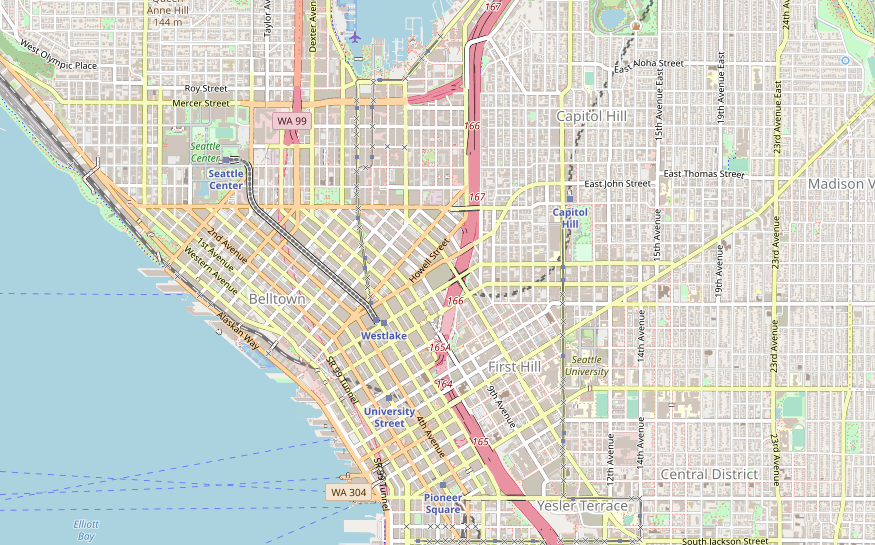

In [1]:
from IPython.display import Image
Image("Seattle.png")

### Objectives

- Assess the quality of the data for validity, accuracy, completeness, consistency and uniformity.
- Parse and gather data
- Process data 
- Learn how to store, query, and aggregate data using SQL.

### Data Auditing and cleaning


I used identifyTags.py to identify the tags used in the datafile.Node and way are the tags I will be looking at. 

TagAudit.py was used to look for tags with only lowercase letters, lowercase letters separated by a colon as well as any problem characters.

AuditingK.py was used to find the different attributes represented by the 'k' value and measures their occurance. 

UsersUnique.py was used to show how many unique users contributed to the file. 

I used StreetTypes.py to audit the street names in the seattle.osm file. 

UpdateStreetTypes.py was used to correct inconsistancies with street names in the seattle.osm file. 


### Tag Identification

This function shows what kind of elements are present in OSM file, and which are important. Reference IdentifyTages.py.

In [2]:
import xml.etree.cElementTree as ET
import pprint

OSMFILE = 'Seattle.osm'
SAMPLE_FILE = 'sample.osm'

def count_tags(filename):
    tags = {}
    for event, elem in ET.iterparse(filename):
        if elem.tag not in tags.keys():
            tags[elem.tag] = 1
        else:
            tags[elem.tag] += 1
    return tags

tags = count_tags(OSMFILE)
pprint.pprint(tags)



{'bounds': 1,
 'member': 70807,
 'meta': 1,
 'nd': 251384,
 'node': 217673,
 'note': 1,
 'osm': 1,
 'relation': 1039,
 'tag': 266030,
 'way': 31137}


### Size of original file

In [3]:
import os
bytes = os.path.getsize('Seattle.osm')
mb = float(bytes / 1000000)
print ("osm file size:", mb, "Mb")

osm file size: 60.230715 Mb


### Sample file creation 

The following function creats a sample file. Reference sample.py. 

In [4]:
k = 25 # Parameter: take every k-th top level element. The value was tuned to get the appropriate sample file size.

def get_element(filename, tags=('node', 'way', 'relation')):
    context = iter(ET.iterparse(filename, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

with open(SAMPLE_FILE, 'w',encoding='utf-8') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')
    # Write every kth top level element
    for i, element in enumerate(get_element(OSMFILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8').decode())
    output.write('</osm>')

In [5]:
import os
bytes = os.path.getsize('sample.osm')
mb = float(bytes / 1000000)
print ("osm file size:", mb, "Mb")

osm file size: 2.447847 Mb



### Auditing the "k" values

The following function finds the different attributes that are represented by the 'k' value and measures their occurance. Reference AuditingK.py. 

In [6]:
import pprint
import xml.etree.cElementTree as ET

def get_types_of_k_attrib(filename, k_attrib_values_dict):
    
    for _, element in ET.iterparse(filename):
        if element.tag == "node" or element.tag == "way":
            for tag in element.iter("tag"):
                #print(tag.attrib['k'])
                if tag.attrib['k'] not in k_attrib_values_dict:
                    k_attrib_values_dict[tag.attrib['k']] = 1
                else:
                    k_attrib_values_dict[tag.attrib['k']] += 1
                tag.clear()
            element.clear()

if __name__ == '__main__':
    
    k_attrib_values_dict = {}
    
    filename = "Seattle.osm"
    get_types_of_k_attrib(filename, k_attrib_values_dict)
    
    #print the top 10 k values appearing in the Seattle.osm file
    import operator
    pprint.pprint(sorted(k_attrib_values_dict.items(),key = operator.itemgetter(1),reverse = True)[1:11])

[('addr:housenumber', 22362),
 ('addr:street', 22350),
 ('addr:postcode', 21781),
 ('addr:city', 21772),
 ('highway', 16704),
 ('building', 14789),
 ('name', 9411),
 ('amenity', 5255),
 ('footway', 5177),
 ('crossing', 3959)]


The function below will will look for tags with only lowercase letters, then lowercase letters separated by a colon and lastly, any problem characters. Reference TagAudit.py.

In [7]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import pprint
import re
import csv
import codecs
import schema
import sqlite3 
import pandas as pd

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&;\'"\?%#$@\,\. \t\r\n]')


def key_type(element, keys):
    if element.tag == "tag":
            if lower.search(element.attrib['k']) != None: 
                keys['lower'] += 1
            elif lower_colon.search(element.attrib['k']) != None:
                keys['lower_colon'] += 1
            elif problemchars.search(element.attrib['k']) != None:
                keys['problemchars'] += 1
            else: 
                keys['other'] += 1
                
        
    return keys

def process_map(file):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(file):
        keys = key_type(element, keys)

    return keys
process_map('Seattle.osm')

{'lower': 144162, 'lower_colon': 116062, 'problemchars': 0, 'other': 5806}

The function below finds the number of contributors. Reference UsersUnique.py.

In [8]:
def get_user(element):
    return

def process_map_user(file):
    users = set()
    for _, element in ET.iterparse(file):
        if element.tag == 'node' or element.tag == 'way' or element.tag == 'relation':
            users.add(element.attrib['user'])
    print("Total Contributors To This Map Area is:", len(users))
process_map_user('Seattle.osm')

Total Contributors To This Map Area is: 852


### Street Types Audit

The code below audits the street names in the seattle.osm file. Reference StreetTypes.py. 

In [9]:
expected = ['Street', 'Avenue', 'Boulevard', 'Road', 'Place', 'Parkway', 'Lane',
            'Drive']

In [10]:

mapping = { "St": "Street",
            "St.": "Street",
            "street": "Street",
            "Ave": "Avenue",
            "Ave.": "Avenue",
            "Blvd": "Boulevard",
            "Blvd.": "Boulevard",
            "Boulavard": "Boulevard",
            "Rd": "Road",
            "Rd.": "Road",
            "RD": "Road",
            "Pl": "Place",
            "Pl.": "Place",
            "PKWY": "Parkway",
            "Pkwy": "Parkway",
            "Ln": "Lane",
            "Ln.": "Lane",
            "Dr": "Drive",
            "Dr.": "Drive"
            }

In [11]:
import xml.etree.cElementTree as ET
import pprint
import re
from collections import defaultdict

datadir = "data"
datafile = "Seattle.osm"

street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected = ['Street', 'Avenue', 'Boulevard', 'Road', 'Place', 'Parkway', 'Lane',
            'Drive']


def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit(osmfile):
    osm_file = open(osmfile, "r", errors = 'ignore')
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

seattle_street_types = audit(datafile)
pprint.pprint(dict(seattle_street_types))

{'Alley': {'Post Alley'},
 'Ave': {'1st Ave',
         '2nd Ave',
         '3131 Elliot Ave',
         '34th Ave',
         '3rd Ave',
         '4th Ave',
         '6th Ave',
         'Westlake Ave'},
 'Broadway': {'Broadway'},
 'Court': {'Broadway Court',
           'East Barclay Court',
           'East Conover Court',
           'East Florence Court',
           'East James Court',
           'East Jansen Court',
           'East Remington Court'},
 'Driveway': {'West Queen Anne Driveway'},
 'East': {'10th Avenue East',
          '11th Avenue East',
          '12th Avenue East',
          '13th Avenue East',
          '14th Avenue East',
          '15th Avenue East',
          '16th Avenue East',
          '17th Avenue East',
          '18th Avenue East',
          '19th Avenue East',
          '20th Avenue East',
          '21st Avenue East',
          '22nd Avenue East',
          '23rd Avenue East',
          '24th Avenue East',
          '25th Avenue East',
          '26th Avenu

While I did see a few very small inconsistancies while auditing the street names, I found the formatting to be mostly clean and consistent. The code below attempts to update the street names. Reference UpdateStreetTypes.py.

In [12]:
import xml.etree.cElementTree as ET
import pprint
import re
from collections import defaultdict

datadir = "data"
datafile = "Seattle.osm"

street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons","East", "North", "West","South"]

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit(osmfile):
    osm_file = open(osmfile, "r", errors = 'ignore')
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

seattle_street_types = audit(datafile)

#Map the abbreviations to the expected types
MAPPING = { "St": "Street",
            "ST.": "Street",
            "STREET":"Street",
            "ST": "Street",
            "Rd.": "Road",
            "Rd": "Road",
            "RD": "Road",
            "Ave": "Avenue",
            "E":"East",
            "Ln":"Lane",
            "N":"North"
            }

def update_street(name, mapping=MAPPING):
    m = street_type_re.search(name)
    if m.group() in mapping:
        boundaries = re.compile(r'\b' + m.group() + r'$')
        name = re.sub(boundaries, mapping[m.group()], name)

    return name

for street_type, ways in seattle_street_types.items():
    for name in ways:
        better_name = update_street(name, mapping=MAPPING)
        print(name, "=>", better_name)

West Denny Way => West Denny Way
East Olive Way => East Olive Way
Olive Way => Olive Way
Alaskan Way => Alaskan Way
Newport Way => Newport Way
Martin Luther King Junior Way => Martin Luther King Junior Way
East Denny Way => East Denny Way
East James Way => East James Way
Denny Way => Denny Way
Yesler Way => Yesler Way
East Yesler Way => East Yesler Way
Broadway => Broadway
South Jackson => South Jackson
Westlake Ave => Westlake Avenue
34th Ave => 34th Avenue
2nd Ave => 2nd Avenue
6th Ave => 6th Avenue
3rd Ave => 3rd Avenue
3131 Elliot Ave => 3131 Elliot Avenue
1st Ave => 1st Avenue
4th Ave => 4th Avenue
Post Alley => Post Alley
West Queen Anne Driveway => West Queen Anne Driveway
Vine St => Vine Street
Yesler => Yesler


### Prepare Data for SQL

The data is now ready to be imported into SQL. The XML data will be parsed through and converted into tabular format into CSV files. The CSV files can then be imported into sqlite. The code used for this process can be found in sqlprep.py.

Audited changes are carried out when converting to CSV in the script below. 

In [13]:
NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

# Create Schema using the schema provided in the project instruction
SCHEMA = schema = {
    'node': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'lat': {'required': True, 'type': 'float', 'coerce': float},
            'lon': {'required': True, 'type': 'float', 'coerce': float},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'node_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    },
    'way': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'way_nodes': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'node_id': {'required': True, 'type': 'integer', 'coerce': int},
                'position': {'required': True, 'type': 'integer', 'coerce': int}
            }
        }
    },
    'way_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    }
}

# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']


#               Helper Functions            
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""
    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k : v for k, v in row.items()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


def update_street(name, mapping):
    street=street_type_re.search(name).group()

    name=name.replace(street, mapping[street])

    return name


#clean_element function take tag['value'] and tag['key'] as input and return the updated tag values 
def clean_element(tag_value, tag_key):
    


    ## clean street names     
    if tag_key=='street':
        street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)
        full_addr=tag_value
        m = street_type_re.search(full_addr)
        if m:
            street_type = m.group() #group(): Return the string matched by the RE
            if street_type not in expected:
                if street_type in mapping:
                    tag_value=update_street(full_addr, mapping) # call update_street function 
    ## return updated tag_value
    return tag_value
                             
## Clean and shape node or way XML element to Python dict

def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=problemchars, default_tag_type='regular'):
   
    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements
   
    ## clean node element
    if element.tag=='node':
        for primary in element.iter():
            for i in node_attr_fields: 
                if i in primary.attrib: 
                    node_attribs[i]=primary.attrib[i]
        if len(element)!=0:
            for j in range(0, len(element)): 
                childelem=element[j]
                tag={}
                if not problem_chars.search(childelem.attrib['k']): ## ignor problematic element
                    tag["id"]=element.attrib["id"]
                    tag["type"]=default_tag_type
                    tag['value']=childelem.attrib['v']
                    if ":" in childelem.attrib['k']:
                        k_and_v=childelem.attrib['k'].split(':',1)
                        tag["type"]=k_and_v[0]
                        tag["key"]=k_and_v[1]
                        if tag["type"]=='addr':
                            tag["value"]=clean_element(tag["value"],tag["key"]) ## call clean_element function
                    else:
                        tag["key"]=childelem.attrib['k']
                        if tag["type"]=='addr':
                            print(tag_value, tag["key"])
                            tag["value"]=clean_element(tag["value"],tag["key"])
                tags.append(tag)
                
        return ({'node': node_attribs, 'node_tags': tags})            
                    
    ## handle way element               
    elif element.tag=='way':
        for primary in element.iter():
            for i in way_attr_fields: 
                if i in primary.attrib: 
                    way_attribs[i]=primary.attrib[i]   
        
        if len(element)!=0: 
            for j in range(0, len(element)): 
                childelem=element[j]
                tag={}
                if childelem.tag=='tag':
                    if not problem_chars.search(childelem.attrib['k']):
                        tag["id"]=element.attrib["id"]
                        tag["type"]=default_tag_type
                        tag["value"]=childelem.attrib['v']
                        if ":" in childelem.attrib['k']:
                            k_and_v=childelem.attrib['k'].split(':',1)
                            tag["key"]=k_and_v[1]
                            tag["type"]=k_and_v[0]
                            if tag["type"]=='addr':
                                tag["value"]=clean_element(tag["value"],tag["key"]) #call clean_element function
                        else:
                            tag["key"]=childelem.attrib['k']
                            if tag["type"]=='addr':
                                tag["value"]=clean_element(tag["value"],tag["key"]) #update tag values
                    tags.append(tag)
                    
                elif childelem.tag=='nd':
                    #print (childelem.attrib['ref'])
                    way_node={}
                    way_node['id']=element.attrib['id'] 
                    way_node['node_id']=childelem.attrib['ref']
                    way_node['position']=j
                    #print(way_node)
                    way_nodes.append(way_node)
                    
        return ({'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags})
    
## process the file, clean and write XML into csv according to given schema

def process_map(file_in):
    """Iteratively process each XML element and write to csv(s)"""
    with codecs.open(NODES_PATH, 'w', encoding='utf-8') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w', encoding='utf-8') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w', encoding='utf-8') as ways_file, \
        codecs.open(WAY_NODES_PATH, 'w', encoding='utf-8') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w', encoding='utf-8') as way_tags_file:
                
        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        
        nodes_writer.writeheader()
        
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()
    
       
        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])
                    
process_map("Seattle.osm")


### Creating SQL Database

The code below creates the sql database I will be using. Reference sqlCreate.py. 

In [15]:
# ref https://stackoverflow.com/questions/50735349/import-csv-into-sqlite3-insert-failed
conn=sqlite3.connect('Seattle.db')
cur = conn.cursor() 
cur.execute("CREATE TABLE nodes ( id INTEGER PRIMARY KEY NOT NULL, lat REAL, lon REAL,\
    user TEXT, uid INTEGER, version INTEGER, changeset INTEGER, timestamp TEXT )")
conn.commit()
node_df = pd.read_csv('nodes.csv', dtype=object)
node_df.to_sql('nodes', conn, if_exists='append', index=False)


cur.execute("CREATE TABLE nodes_tags (\
    id INTEGER,\
    key TEXT,\
    value TEXT,\
    type TEXT,\
    FOREIGN KEY (id) REFERENCES nodes(id)\
)")
conn.commit()
nodetag_df=pd.read_csv('nodes_tags.csv')
nodetag_df.to_sql('nodes_tags', conn, if_exists='append', index=False)

cur.execute("CREATE TABLE ways (\
    id INTEGER PRIMARY KEY NOT NULL,\
    user TEXT,\
    uid INTEGER,\
    version TEXT,\
    changeset INTEGER,\
    timestamp TEXT\
)")
conn.commit()
way_df=pd.read_csv('ways.csv')
way_df.to_sql('ways', conn, if_exists='append', index=False)

cur.execute("CREATE TABLE ways_nodes (\
    id INTEGER NOT NULL,\
    node_id INTEGER NOT NULL, \
    position INTEGER NOT NULL, \
    FOREIGN KEY (id) REFERENCES ways(id),\
    FOREIGN KEY (node_id) REFERENCES nodes(id)\
)")
conn.commit()
waynode_df=pd.read_csv('ways_nodes.csv')
waynode_df.to_sql('ways_nodes', conn, if_exists='append', index=False)


cur.execute("CREATE TABLE ways_tags (\
    id INTEGER NOT NULL,\
    key TEXT NOT NULL,\
    value TEXT NOT NULL,\
    type TEXT,\
    FOREIGN KEY (id) REFERENCES ways(id)\
)")
conn.commit()
waytag_df=pd.read_csv('ways_tags.csv')
waytag_df=waytag_df.dropna(subset=['id', 'key', 'value'], how='any')
waytag_df.to_sql('ways_tags', conn, if_exists='append', index=False)

OperationalError: table nodes already exists

### Exploring the data further with SQL

### Top 5 amenitities

For fun, I took a look at the top 5 amenities in my osm file. 

In [16]:
query = ("SELECT tags.value, COUNT(*) as count \
            FROM (SELECT * FROM nodes_tags \
            UNION ALL \
            SELECT * FROM ways_tags) tags \
            WHERE tags.key='amenity' \
            GROUP BY tags.value \
            ORDER BY count DESC \
            LIMIT 5")
cur.execute(query)
top_5_amenities = cur.fetchall()
print ("Top 5 amenities:\n")
pprint.pprint(top_5_amenities)

Top 5 amenities:

[('bicycle_parking', 1400),
 ('parking', 663),
 ('restaurant', 619),
 ('waste_basket', 417),
 ('cafe', 362)]


This being Seattle, it is not surprising to see cafes in the top 5 amenities. 

In [17]:
query = ("SELECT tags.value, COUNT(*) as count \
            FROM (SELECT * FROM nodes_tags \
            UNION ALL \
            SELECT * FROM ways_tags) tags \
            JOIN (SELECT DISTINCT(id) FROM (SELECT * FROM nodes_tags \
            UNION ALL \
            SELECT * FROM ways_tags) WHERE value = 'cafe') as subq \
            ON tags.id = subq.id \
            WHERE tags.key = 'street' \
            GROUP BY tags.value \
            ORDER BY count DESC \
            LIMIT 5")
cur.execute(query)
top_5_caf_street = cur.fetchall()
print ("Top 5 streets by cafe:\n")
pprint.pprint(top_5_caf_street)

Top 5 streets by cafe:

[('3rd Avenue', 14),
 ('1st Avenue', 13),
 ('East Pike Street', 11),
 ('4th Avenue', 11),
 ('2nd Avenue', 8)]


It looks like 3rd Avenue in downtown Seattle is the street with the highest number of cafes. 

### Conclusion

The datafile I used from OpenStreetMap was surprisingly consistant given the size of the file and the number of users. 
In general, the file was cleaner than expected. 

This project was a good way to learn data gathering, auditing, cleaning and analysis. It was also valuable to learn how to
create and import data into an SQL database. 

I might suggest that OpenStreetMap somehow provide data validation checks to avoid erroneous data entry into the OSM database.


### Submission

- [x]  A pdf document containing your answers to the rubric questions. This file should document your data wrangling process.
- [x]  Your Python code you used in auditing and cleaning your dataset for the final project. 
- [x]  A text file containing a link to the map position you wrangled in your project, a short description of the area and a reason for your choice.
- [x]  An .osm file containing a sample part of the map region you used (around 1 - 10 MB in size). 

Common mistakes and warnings

- [x]  If you've been working on this project through a Jupyter Notebook, make sure that your code is transferred to standalone .py scripts before submitting your work. It is recommended that you have one script for each field that you audit, and one script that converts and cleans your data. Make sure that your code is well-commented and organized so that your reviewer can follow your work.
- [x]  Your code should carry out cleaning operations on one of the fields that you investigate. Make sure that you've performed some programmatic cleaning as part of your project work: you don't need to clean all of the problems in your dataset, but you should at least address the most common issues observed.
- [x]  Make sure that your scripts carry out the functionality of your cleaning steps. One common mistake is to create scripts that target specific audits of the code, but the audited changes are not actually carried out when the XML data is converted to JSON or CSV for insertion into your chosen database.